In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.nn.utils.rnn import pack_padded_sequence    
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
%matplotlib inline
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [68]:
import random
#Cell to verify data formats
test3 = pd.read_csv('/Users/JosephVele/Downloads/all/train_photo_to_biz_ids.csv')
captions  = test3.iloc[0,2]
captions = captions.split()
length = len(captions)
random.shuffle(captions)
captions = list(map(int, captions))
captions = [9]+ captions + [10]
captions = [x+1 for x in captions]
for i in range(11 - length):
    captions= captions + [0]

length= length + 2

print(length)
print(torch.Tensor(captions).long())

8
tensor([10,  3,  8,  2,  6,  7,  5, 11,  0,  0,  0,  0,  0])


In [88]:
# Cell 3
class yelpDataset(torch.utils.data.Dataset):
    
    def __init__(self,text_file,root_dir, transform):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        
        self.name_frame = pd.read_csv(text_file,sep=",",usecols=range(1),dtype = 'str',nrows = 100000)
        self.label_frame = pd.read_csv(text_file,sep=",",  nrows=100000)
        self.root_dir = root_dir
        self.transform = transform
                                       
    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        #photoid = self.name_frame.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, self.name_frame.iloc[idx, 0]  +'.jpg')
        #print(img_name)
        image = Image.open(img_name)
        image = image.convert('RGB')
        image = self.transform(image) 
        labels = self.label_frame.iloc[idx,2] #Extract labels in the format ['1 2 3 4']
        labels = labels.split() #Make into list ['1','2','3','4']
        
        labels = list(map(int, labels)) #Convert to int
        #random.shuffle(labels)
        labels = [9] + labels + [10] # Include start and end
        labels = [x+1 for x in labels] # Add 1 to all labels so 0 has no meaning
        length = len(labels) 
        for i in range(11 - length): #Pad the labels (There are 9 unique labels)
            labels = labels + [0]
        
         
        target = torch.Tensor(labels).long()
        
        sample = {'image': image, 'labels': target, 'lengths': length}
        
        return sample
    

In [89]:
#Alexnet requires 227 x 227
yelpTrainSet = yelpDataset(text_file ='/Users/JosephVele/Downloads/all/train_photo_to_biz_ids.csv',
                           root_dir = '/Users/JosephVele/Downloads/all/train_photos',
                          transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean = [0.485, 0.456, 0.406],
                                                              std = [0.229, 0.224, 0.225])]))

yelpTrainLoader = torch.utils.data.DataLoader(yelpTrainSet,batch_size=256,shuffle=True, num_workers=0)



In [90]:

import math
def spatial_pyramid_pool(self,previous_conv, num_sample, previous_conv_size, out_pool_size):
    '''
    previous_conv: a tensor vector of previous convolution layer
    num_sample: an int number of image in the batch
    previous_conv_size: an int vector [height, width] of the matrix features size of previous convolution layer
    out_pool_size: a int vector of expected output size of max pooling layer
    
    returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
    '''    
    # print(previous_conv.size())
    for i in range(len(out_pool_size)):
        # print(previous_conv_size)
        h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
        h_pad = (h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2
        w_pad = (w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2
        maxpool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(h_pad, w_pad))
        x = maxpool(previous_conv)
        if(i == 0):
            spp = x.view(num_sample,-1)
            # print("spp size:",spp.size())
        else:
            # print("size:",spp.size())
            spp = torch.cat((spp,x.view(num_sample,-1)), 1)
    return spp

In [71]:

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        alex_net = models.alexnet(pretrained=True)
        alex_net.classifier._modules['6'] = nn.Linear(4096, embed_size)
        #vgg19.classifier._modules['6']  = nn.Linear(4096, embed_size)
        
        self.alex_net = alex_net
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.alex_net(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=11):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [72]:
 #Cell 6
 
 vocab = ['<padding>','good_for_lunch','good_for_dinner','takes_reservations','outdoor_seating','restaurant_is_expensive',
         'has_alcohol','has_table_service','ambience_is_classy', 'good_for_kids','<start>', '<end>']

embed_size = 1024
hidden_size = 512
num_layers = 1
# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

learning_rate = .001
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.alex_net.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)


In [85]:
#Cell 7
num_epochs = 5
total_step = len(yelpTrainLoader)
log_step = 100
train_losses = []
for epoch in range(num_epochs):
    train_loss = 0
    for i, sample_batched in enumerate(yelpTrainLoader):
        
        # Set mini-batch dataset
        unsorted_images = sample_batched['image'].to(device)
        unsorted_labels = sample_batched['labels'].to(device)
        unsorted_lengths = sample_batched['lengths']
        sorted_length_index = sorted(range(len(unsorted_lengths)),key=unsorted_lengths.__getitem__,reverse=True)
        inputs =[]
        labels = []
        lengths = []
        for j in sorted_length_index:
            inputs.append(unsorted_images[j])
            labels.append(unsorted_labels[j])
            lengths.append(unsorted_lengths[j])
            
        inputs =torch.stack(inputs)
        labels = torch.stack(labels)
        lengths = torch.stack(lengths)
        targets = pack_padded_sequence(labels , lengths, batch_first=True)[0]
        #print(labels)
        #print(targets)
        # Forward, backward and optimize
        features = encoder(inputs)
        outputs = decoder(features, labels , lengths)
        #print(outputs)
        #print(np.shape(outputs))
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
    train_loss = train_loss/i
    train_losses.append([epoch, train_loss ])

Epoch [0/5], Step [0/391], Loss: 0.4315, Perplexity: 1.5396
Epoch [0/5], Step [100/391], Loss: 0.4647, Perplexity: 1.5915
Epoch [0/5], Step [200/391], Loss: 0.4643, Perplexity: 1.5909
Epoch [0/5], Step [300/391], Loss: 0.4745, Perplexity: 1.6072
Epoch [1/5], Step [0/391], Loss: 0.4336, Perplexity: 1.5427
Epoch [1/5], Step [100/391], Loss: 0.4465, Perplexity: 1.5629
Epoch [1/5], Step [200/391], Loss: 0.4356, Perplexity: 1.5458
Epoch [1/5], Step [300/391], Loss: 0.4431, Perplexity: 1.5576
Epoch [2/5], Step [0/391], Loss: 0.4045, Perplexity: 1.4985
Epoch [2/5], Step [100/391], Loss: 0.4054, Perplexity: 1.5000
Epoch [2/5], Step [200/391], Loss: 0.4021, Perplexity: 1.4950
Epoch [2/5], Step [300/391], Loss: 0.3940, Perplexity: 1.4829
Epoch [3/5], Step [0/391], Loss: 0.3637, Perplexity: 1.4387
Epoch [3/5], Step [100/391], Loss: 0.3919, Perplexity: 1.4798
Epoch [3/5], Step [200/391], Loss: 0.4154, Perplexity: 1.5150
Epoch [3/5], Step [300/391], Loss: 0.3814, Perplexity: 1.4643
Epoch [4/5], Ste

In [86]:
PATH = '/Users/JosephVele/Documents/gradschool_year2/CS7180/Yelp Project/alex_cnn_encoder.pth'
torch.save(encoder.state_dict(), PATH)
PATH = '/Users/JosephVele/Documents/gradschool_year2/CS7180/Yelp Project/alex_rnn_decoder.pth'
torch.save(decoder.state_dict(), PATH)

[2 3 5 6 7 8]


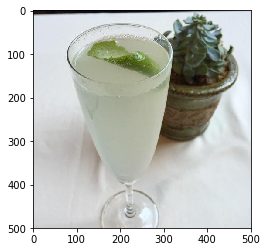

<start> good_for_dinner takes_reservations restaurant_is_expensive has_alcohol has_table_service ambience_is_classy <end>
[1 9]


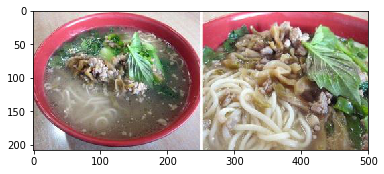

<start> good_for_lunch good_for_kids <end>
[1 2 3 7 9]


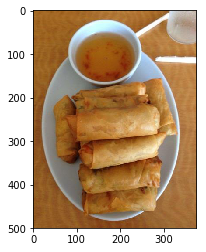

<start> good_for_lunch good_for_dinner takes_reservations has_table_service good_for_kids <end>
[2 3 5 6 7 8]


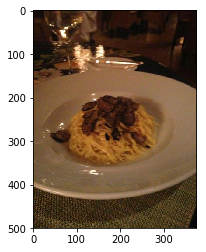

<start> good_for_dinner takes_reservations restaurant_is_expensive has_alcohol has_table_service ambience_is_classy <end>
[2 3 5 6 7 8]


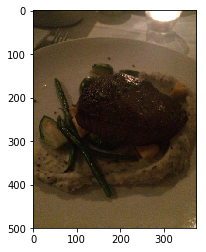

<start> good_for_dinner takes_reservations restaurant_is_expensive has_alcohol has_table_service ambience_is_classy <end>
[9]


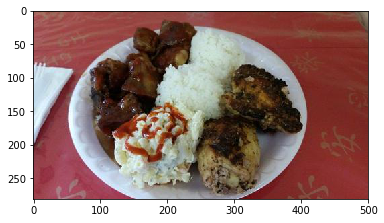

<start> good_for_kids <end>


In [87]:

import cv2

photos = ['200115','200116','200117','200119','200121', '200122']

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([227, 227], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

vocab = ['<padding>','good_for_lunch','good_for_dinner','takes_reservations',
         'outdoor_seating','restaurant_is_expensive',
         'has_alcohol','has_table_service','ambience_is_classy', 'good_for_kids','<start>', '<end>']

embed_size = 256
hidden_size = 512
num_layers = 1

for i in photos:
    img_name = os.path.join('/Users/JosephVele/Downloads/all/train_photos', i  +'.jpg')

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    encoder.eval()
    decoder.eval()
    
    # Prepare an image
    image = load_image(img_name, transform)
    image_tensor = image.to(device)
    
        # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    pred = sampled_ids
    
    end = np.argwhere(pred==11)[0][0]
    start = np.argwhere(pred==10)[0][0]+1
    pred = pred[start:end]
    print(pred)
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    
    image = cv2.imread(img_name)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.show()
    print (sentence)

In [84]:
#Cell 9               
test3 = pd.read_csv('/Users/JosephVele/Downloads/all/test_photo_to_biz_ids.csv')

vocab = ['<padding>',
         'good_for_lunch',
         'good_for_dinner',
         'takes_reservations',
         'outdoor_seating',
         'restaurant_is_expensive',
         'has_alcohol',
         'has_table_service',
         'ambience_is_classy',
         'good_for_kids',
         '<start>', '<end>']   
test3.head(5)
    

,photo_id,business_id,label,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Label_7,Label_8
0,200115,5,1 2 4 5 6 7,0,1,1,0,1,1,1,1,0
1,200116,1850,0 8,1,0,0,0,0,0,0,0,1
2,200117,1080,2 3 6 8,0,0,1,1,0,0,1,0,1
3,200119,2586,2 3 4 5 6 7 8,0,0,1,1,1,1,1,1,1
4,200121,525,1 2 4 5 6 7,0,1,1,0,1,1,1,1,0


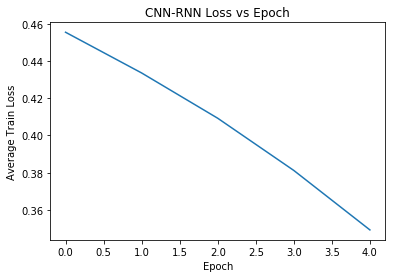

In [102]:
plt.plot ( pd.DataFrame(train_losses)[0], pd.DataFrame(train_losses)[1])
plt.xlabel('Epoch')
plt.ylabel('Average Train Loss')
plt.title('CNN-RNN Loss vs Epoch')
plt.show()

In [78]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([227, 227], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

vocab = ['<padding>','good_for_lunch','good_for_dinner','takes_reservations',
         'outdoor_seating','restaurant_is_expensive',
         'has_alcohol','has_table_service','ambience_is_classy', 'good_for_kids','<start>', '<end>']


TP, TN, FP, FN = 0, 0, 0, 0

photos = pd.read_csv('/Users/JosephVele/Downloads/all/test_photo_to_biz_ids.csv',
                     sep=",",dtype = 'str')

for i, j  in zip(photos['photo_id'], photos['label']):

    labels = j.split() #Make into list ['1','2','3','4']       
    labels = list(map(int, labels)) #Convert to int
    labels = [x+1 for x in labels] # Add 1 to all labels so 0 has no meaning
    
    #print(labels)
    
    img_name = os.path.join('/Users/JosephVele/Downloads/all/train_photos', i  +'.jpg')

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    encoder.eval()
    decoder.eval()
    
    # Prepare an image
    image = load_image(img_name, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    pred = sampled_ids
    
    end = np.argwhere(pred==11)[0][0]
    start = np.argwhere(pred==10)[0][0]+1
    pred = pred[start:end]
    #print(pred)
    
    pred2 = np.zeros(9)
    labels2 = np.zeros(9)
    for i in pred:
        pred2[i-1]=1
    for i in labels:
        labels2[i-1]=1   
    TP += ((pred2==1)==(labels2==1)).sum()
    TN += ((pred2==0)==(labels2==0)).sum()
    FP += ((pred2==1)==(labels2==0)).sum()
    FN += ((pred2==0)==(labels2==1)).sum()

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = 2 * (precision*recall)/(precision+recall)
print('Test: Accuracy: {:.2f}\tPrecision: {:.2f}\t Recall: {:.2f}\t F1 Score: {:.2f}\n'.
          format(accuracy,  precision, recall, f1_score))

Test: Accuracy: 0.71	Precision: 0.71	 Recall: 0.71	 F1 Score: 0.71



In [83]:
TP + FP +FN +TN

360000

51683

51683

128317